In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from simulations import sim_randomised, sim_constrained, sim_automated
import random
import matplotlib.pyplot as plt
from torch.distributions import Categorical


In [9]:
class ActorCritic(nn.Module):
    def __init__(self, n_states, n_actions):
        super(ActorCritic, self).__init__()
        # Network layers !! Replace with GNN implementation
        
        self.actor = nn.Sequential(
            nn.Linear(n_states, 64),
            nn.PReLU(),
            nn.Linear(64, 64),
            nn.Sigmoid(),
            
            nn.Linear(64, n_actions),
        )
        self.critic = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.PReLU(),
            
            nn.Linear(64, 32),
            
            nn.PReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, state,action_mask=torch.zeros(220),temperature=1.0):
        logits = self.actor(state) / temperature
        #print(logits, "direct logits")
        logits += action_mask
        #print(logits)
        
        action_probs = F.softmax(logits, dim=-1)
        state_value = self.critic(state)
        return action_probs, state_value

In [6]:
class PPO:
    def __init__(self, n_states, n_actions, lr_actor, lr_critic, gamma, K_epochs, eps_clip, gae_lambda):
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.gae_lambda = gae_lambda

        self.policy = ActorCritic(n_states, n_actions)
        self.optimizer = optim.Adam([
            {'params': self.policy.actor.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic.parameters(), 'lr': lr_critic}
        ])

        self.policy_old = ActorCritic(n_states, n_actions)
        self.policy_old.load_state_dict(self.policy.state_dict())

        self.MseLoss = nn.MSELoss()

    def select_action(self, state, memory,action_mask, temperature=1.0):
        state = torch.FloatTensor(state.reshape(1, -1))
        with torch.no_grad():
            masked_action_probs, _ = self.policy_old(state,action_mask,temperature)
            
        #masked_action_probs = (action_probs + 0.00001) * action_mask
        #print(masked_action_probs)
        
        #total_probs = torch.sum(masked_action_probs)
        #if total_probs > 0:
        #    normalized_probs = masked_action_probs / total_probs
            
        #action = np.random.choice(len(masked_action_probs.squeeze()), p=masked_action_probs.squeeze().numpy())
        #print(masked_action_probs)
        #action = torch.multinomial(masked_action_probs, 1).item()
        
        
        dist = Categorical(masked_action_probs)
        action = dist.sample()
        
        
        memory.states.append(state)
        memory.actions.append(action)
        memory.logprobs.append(dist.log_prob(action))

        return action

    def update(self, memory):
        gae, targets = self.calculate_gae_and_targets(memory)


        old_states = torch.squeeze(torch.stack(memory.states))
        old_actions = torch.squeeze(torch.stack(memory.actions)).detach()
        old_logprobs = torch.squeeze(torch.stack(memory.logprobs)).detach()

        for _ in range(self.K_epochs):
            # Evaluate old actions and values
            logprobs, state_values = self.policy(old_states)
            state_values = torch.squeeze(state_values)
            dist_entropy = -torch.sum(logprobs * torch.exp(logprobs), dim=1)
            new_logprobs = logprobs.gather(1, old_actions.view(-1, 1)).squeeze()
            
            # Find the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(new_logprobs - old_logprobs)
            
            # Calculate surrogate losses
            surr1 = ratios * gae
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * gae
            
            # Final loss
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, targets) - 0.01*dist_entropy
            
            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
        
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())
        
    def calculate_gae_and_targets(self, memory):
        gae = 0
        targets = []
        gae_values = []
        values = memory.values + [0]
    
        for i in reversed(range(len(memory.rewards))):
            delta = memory.rewards[i] + self.gamma * values[i+1] * (1 - memory.is_terminals[i]) - values[i]
            gae = delta + self.gamma * self.gae_lambda * gae * (1 - memory.is_terminals[i])
            gae_values.insert(0, gae)
            targets.insert(0, gae + values[i])

        gae_values = torch.tensor(gae_values, dtype=torch.float32)
        targets = torch.tensor(targets, dtype=torch.float32)

        return gae_values, targets


        
        # Monte Carlo estimate of state rewards:
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing the rewards
        rewards = torch.tensor(rewards)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # Convert list to tensor
        old_states = torch.squeeze(torch.stack(memory.states).detach())
        old_actions = torch.squeeze(torch.tensor(memory.actions).detach())

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):
            # Evaluating old actions and values
                        

            logprobs, state_values = self.policy(old_states)
            state_values = torch.squeeze(state_values)

                # Match state-action pairs
            dist_entropy = -torch.sum(logprobs * torch.exp(logprobs), dim=1)
            new_logprobs = logprobs.gather(1, old_actions.unsqueeze(1)).squeeze(1)
            
            old_logprobs = self.policy_old(old_states)[0].gather(1, old_actions.unsqueeze(1)).squeeze(1)

            # Calculate ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(new_logprobs - old_logprobs.detach())

            # Calculate surrogate losses
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # Final loss
            loss = -torch.min(surr1, surr2).mean() + self.MseLoss(state_values, rewards) - 0.01*dist_entropy

            # Take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())


In [4]:
class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.rewards = []
        self.is_terminals = []
        self.logprobs = []
        self.values = []


    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.rewards[:]
        del self.is_terminals[:]
        del self.logprobs[:]
        del self.values[:]


/Users/hazarckr/Documents/Semester_3/idp/schedulingGNN/simulations/sim_constrained.py:235: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  o_id = value //  len(self.resources)


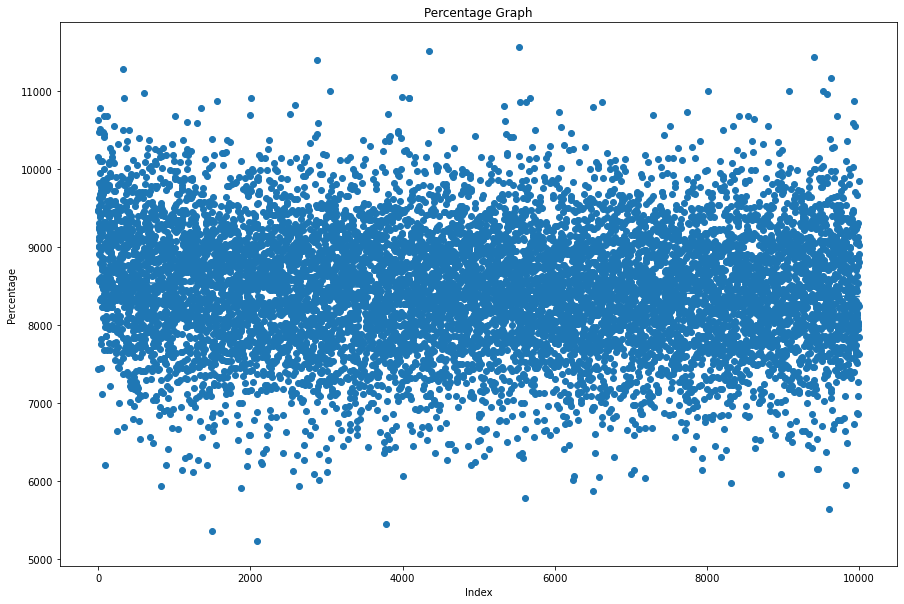

In [11]:
# Initialize your environment and the PPO agent
env = sim_constrained.Env(visualise=False, verbose=False, model=True,goal="min_time")
n_states = env.n_states
n_actions = env.n_actions

ppo_agent = PPO(n_states, n_actions, lr_actor=0.00004, lr_critic=0.001, gamma=0.99, K_epochs=7, eps_clip=0.18, gae_lambda=0.95)
memory = Memory()

initial_temperature = 10  # Starting temperature
final_temperature = 1    # Minimum temperature
decay_rate = 0.001          # Rate of temperature decay
current_temperature = initial_temperature

# Training loop
num_episodes = 10000
success_rates = []

for episode in range(num_episodes):
    
    current_temperature = max(final_temperature, initial_temperature * (1 - decay_rate * episode))

    state, action_mask = env.reset()
    #print(current_temperature)
    
    done = False

    while not done:
        action = ppo_agent.select_action(state, memory, action_mask)
        #print(action)
        state, reward, done, action_mask, success_rate = env.step(action)
        #print(reward)

        # Save in memory
        memory.rewards.append(reward)
        memory.is_terminals.append(done)
        _, state_value = ppo_agent.policy_old(torch.FloatTensor(state).unsqueeze(0))
        memory.values.append(state_value)
        
    
    success_rates.append(success_rate)
    #print(success_rate)
    # Update PPO agent
    ppo_agent.update(memory)
    memory.clear_memory()

    # Log results, etc.

    
    
x = range(len(success_rates))
# Creating the plot
plt.figure(figsize=(15, 10))  

a, b = np.polyfit(x,success_rates , 1)

plt.scatter(x, success_rates)

plt.plot(x, a*x+b)

# Adding title and labels
plt.title('Percentage Graph')
plt.xlabel('Index')
plt.ylabel('Percentage')

# Show the plot
plt.show()

In [ ]:
print(max(success_rates))

In [ ]:
print(n_states,n_actions)